In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2023-03-05 14:19:29.376056: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# download dataset
zip_file = keras.utils.get_file(
    fname='cora.tgz',
    origin='https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz',
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), 'cora')

In [3]:
citations = pd.read_csv(
    os.path.join(data_dir, 'cora.cites'),
    sep='\t',
    header=None,
    names=['target', 'source']
)
print('citation shape', citations.shape)

citation shape (5429, 2)


In [4]:
citations.sample(frac=1).head()

,target,source
1098,5075,1120563
3717,80515,314459
2079,16471,273949
3275,52515,446271
1653,9716,28674


In [5]:
# load data
column_names = ['paper_id'] + [f'term_{idx}' for idx in range(1433)] + ['subject']
papers = pd.read_csv(
    os.path.join(data_dir, 'cora.content'),
    sep='\t',
    header=None,
    names=column_names
)
print('papers shape:', papers.shape)


papers shape: (2708, 1435)


In [6]:
print(papers.sample(5).T)

                      350              1966                   641     967   \
paper_id             29492           131317                  18811   89547   
term_0                   0                0                      0       0   
term_1                   0                0                      0       0   
term_2                   0                0                      0       0   
term_3                   0                1                      0       0   
...                    ...              ...                    ...     ...   
term_1429                0                0                      0       0   
term_1430                0                0                      0       0   
term_1431                0                0                      0       0   
term_1432                0                0                      0       0   
subject    Neural_Networks  Neural_Networks  Probabilistic_Methods  Theory   

              1361  
paper_id   1133028  
term_0           0  


In [7]:
print(papers.subject.value_counts())

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64


In [8]:
class_values = sorted(papers['subject'].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers['paper_id'].unique()))}

In [9]:
papers['paper_id'] = papers['paper_id'].apply(lambda name: paper_idx[name])
citations['target'] = citations['target'].apply(lambda name: paper_idx[name])
citations['source'] = citations['source'].apply(lambda name: paper_idx[name])
papers['subject'] = papers['subject'].apply(lambda value: class_idx[value])

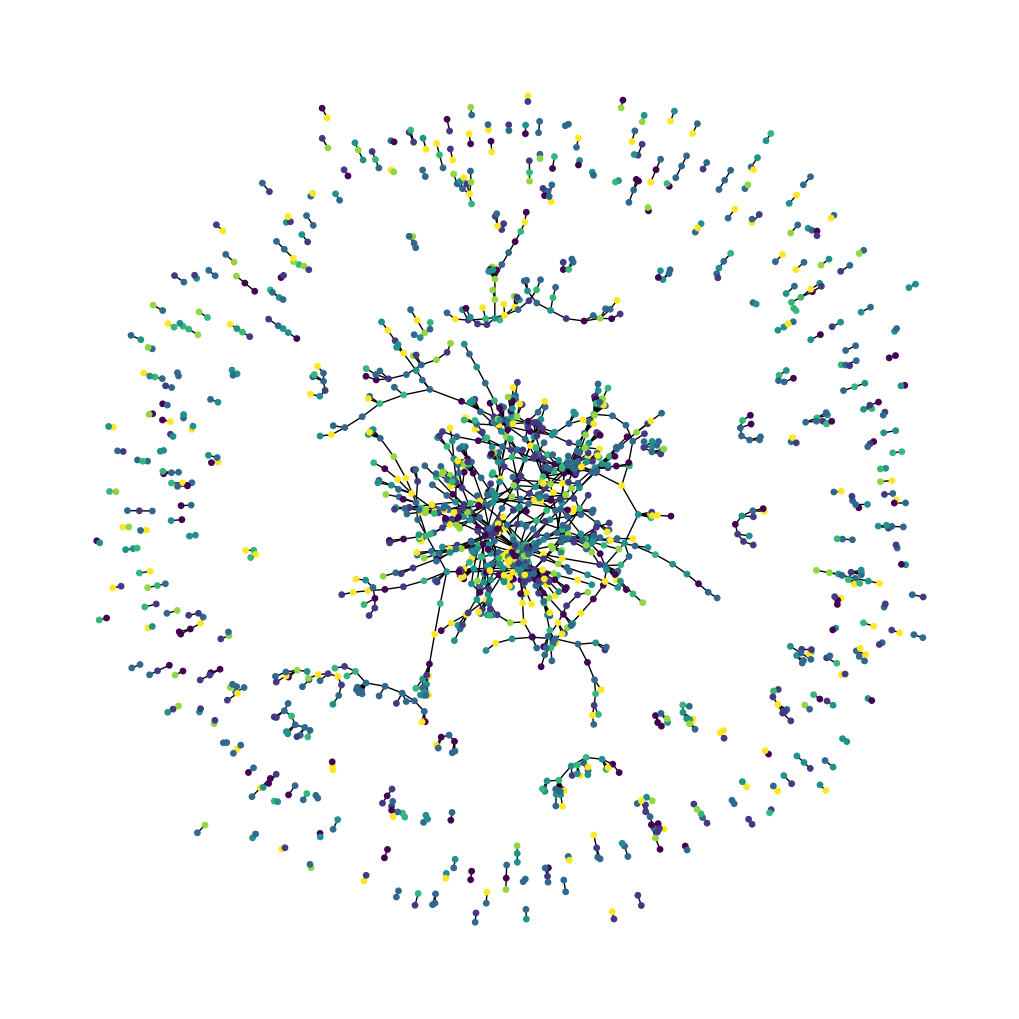

In [10]:
# visualization
plt.figure(figsize=(10, 10))
colors = papers['subject'].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(1500)) # using 1500 samples draw figure
subjects = list(papers[papers['paper_id'].isin(list(cora_graph.nodes))]['subject'])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

In [11]:
# split dataset into stratified train and test sets
train_data, test_data = [], []

for _, group_data in papers.groupby('subject'):
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

In [12]:
train_data = pd.concat(train_data)
test_data = pd.concat(test_data)
print('train data shape:', train_data.shape)
print('test data shape:', test_data.shape)

train data shape: (1358, 1435)
test data shape: (1350, 1435)


In [13]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [14]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [15]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [16]:
# We will use this module in the baseline and the GNN models
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [17]:
# Prepare the data for the baseline model
feature_names = list(set(papers.columns) - {'paper_id', 'subject'})
num_features = len(feature_names)
num_classes = len(class_idx)

# create train and test feature as a numpy array
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# create train and test targets as a numpy array
y_train = train_data['subject']
y_test = test_data['subject']

In [18]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name='input_features')
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # create an fnn block
        x1 = create_ffn(hidden_units, dropout_rate, name=f'fnn_block{block_idx + 2}')(x)
        # add skip connection
        x = layers.Add(name=f'skip_connection{block_idx + 2}')([x, x1])
    # compute logits
    logits = layers.Dense(num_classes, name='logits')(x)
    # create the model
    return keras.Model(inputs=inputs, outputs=logits, name='baseline')

baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

2023-03-05 14:19:44.966899: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-05 14:19:44.968923: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 1433)]       0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           52804       ['input_features[0][0]']         
                                                                                                  
 fnn_block2 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 32)           0           ['ffn_block1[0][0]',             
                                                                  'fnn_block2[0][0]']      

In [19]:
history = run_experiment(baseline_model, x_train, y_train)

/home/ouconstand/software/anaconda3/lib/python3.8/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/300
5/5 [==============================] - 5s 234ms/step - loss: 4.0162 - acc: 0.1586 - val_loss: 1.9062 - val_acc: 0.0000e+00
Epoch 2/300
5/5 [==============================] - 0s 84ms/step - loss: 2.5187 - acc: 0.2998 - val_loss: 1.8876 - val_acc: 0.0000e+00
Epoch 3/300
5/5 [==============================] - 0s 63ms/step - loss: 2.2492 - acc: 0.3050 - val_loss: 1.8029 - val_acc: 0.0098
Epoch 4/300
5/5 [==============================] - 1s 116ms/step - loss: 2.1014 - acc: 0.2972 - val_loss: 1.7405 - val_acc: 0.3235
Epoch 5/300
5/5 [==============================] - 0s 38ms/step - loss: 1.8161 - acc: 0.3406 - val_loss: 1.7363 - val_acc: 0.5637
Epoch 6/300
5/5 [==============================] - 1s 76ms/step - loss: 1.7412 - acc: 0.3492 - val_loss: 1.7201 - val_acc: 0.7157
Epoch 7/300
5/5 [==============================] - 1s 124ms/step - loss: 1.6275 - acc: 0.3847 - val_loss: 1.7764 - val_acc: 0.5735
Epoch 8/300
5/5 [==============================] - 0s 96ms/step - loss: 1.5902 

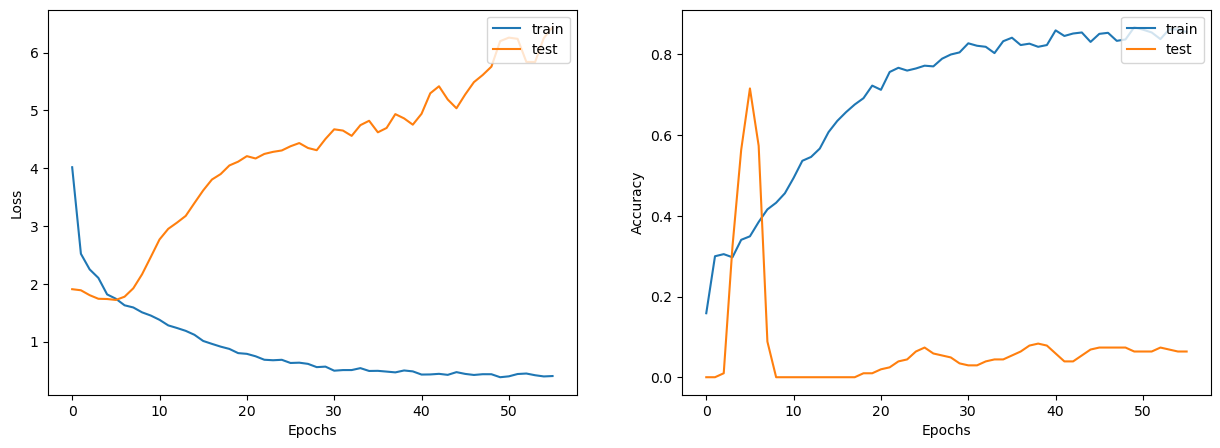

In [20]:
display_learning_curves(history)

In [21]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f'test accuracy : {round(test_accuracy * 100, 2)}%')

test accuracy : 18.59%


In [22]:
def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")

In [23]:
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

1/1 [==============================] - 0s 315ms/step
Instance 1:
- Case_Based: 15.31%
- Genetic_Algorithms: 12.81%
- Neural_Networks: 18.39%
- Probabilistic_Methods: 13.55%
- Reinforcement_Learning: 12.09%
- Rule_Learning: 10.2%
- Theory: 17.64%
Instance 2:
- Case_Based: 15.35%
- Genetic_Algorithms: 12.12%
- Neural_Networks: 16.97%
- Probabilistic_Methods: 13.42%
- Reinforcement_Learning: 13.12%
- Rule_Learning: 9.67%
- Theory: 19.35%
Instance 3:
- Case_Based: 16.45%
- Genetic_Algorithms: 12.02%
- Neural_Networks: 18.95%
- Probabilistic_Methods: 11.71%
- Reinforcement_Learning: 10.83%
- Rule_Learning: 9.74%
- Theory: 20.31%
Instance 4:
- Case_Based: 15.6%
- Genetic_Algorithms: 12.11%
- Neural_Networks: 17.31%
- Probabilistic_Methods: 12.48%
- Reinforcement_Learning: 14.0%
- Rule_Learning: 9.46%
- Theory: 19.04%
Instance 5:
- Case_Based: 18.15%
- Genetic_Algorithms: 12.69%
- Neural_Networks: 17.16%
- Probabilistic_Methods: 12.82%
- Reinforcement_Learning: 14.53%
- Rule_Learning: 10.86%


In [24]:
# create an edges array (sparse adjacency matrix) of shape [2, num_edges]
edges = citations[['source', 'target']].to_numpy().T
# create an edge weights arrat of ones
edge_weights = tf.ones(shape=edges.shape[1])
# create a node feature array of shape [num_nodes, num_features]
node_features = tf.cast(
    papers.sort_values('paper_id')[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# create graph info tuple with node_feature, edges, and edge_weights
graph_info = (node_features, edges, edge_weights)

print('edges shape:', edges.shape)
print('nodes shape:', node_features.shape)

edges shape: (2, 5429)
nodes shape: (2708, 1433)


In [25]:
edges.shape[1]

5429

In [26]:
edge_weights.shape

TensorShape([5429])

In [27]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim]
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

In [28]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

In [29]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[ 0.00607263 -0.05656257  0.02459839  0.10102013  0.01419971  0.04375182
   0.05425809]
 [-0.09304529  0.05490581 -0.12301885  0.07854676 -0.05440074 -0.07651956
  -0.04096854]
 [-0.14900441 -0.06641266 -0.15384878  0.08553766 -0.07105545  0.00116155
  -0.03920901]], shape=(3, 7), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (2708, 32)                52804     
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                            

In [30]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300


/home/ouconstand/software/anaconda3/lib/python3.8/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


5/5 [==============================] - 5s 360ms/step - loss: 2.0263 - acc: 0.2686 - val_loss: 2.0192 - val_acc: 0.0000e+00
Epoch 2/300
5/5 [==============================] - 2s 336ms/step - loss: 1.8436 - acc: 0.3033 - val_loss: 2.1422 - val_acc: 0.0000e+00
Epoch 3/300
5/5 [==============================] - 2s 322ms/step - loss: 1.7564 - acc: 0.3050 - val_loss: 2.3036 - val_acc: 0.0000e+00
Epoch 4/300
5/5 [==============================] - 2s 367ms/step - loss: 1.7247 - acc: 0.3033 - val_loss: 2.4883 - val_acc: 0.0000e+00
Epoch 5/300
5/5 [==============================] - 2s 381ms/step - loss: 1.6995 - acc: 0.3189 - val_loss: 2.6606 - val_acc: 0.0000e+00
Epoch 6/300
5/5 [==============================] - 1s 295ms/step - loss: 1.6900 - acc: 0.3362 - val_loss: 2.8897 - val_acc: 0.0000e+00
Epoch 7/300
5/5 [==============================] - 2s 350ms/step - loss: 1.6514 - acc: 0.3397 - val_loss: 3.2047 - val_acc: 0.0000e+00
Epoch 8/300
5/5 [==============================] - 2s 329ms/step - 

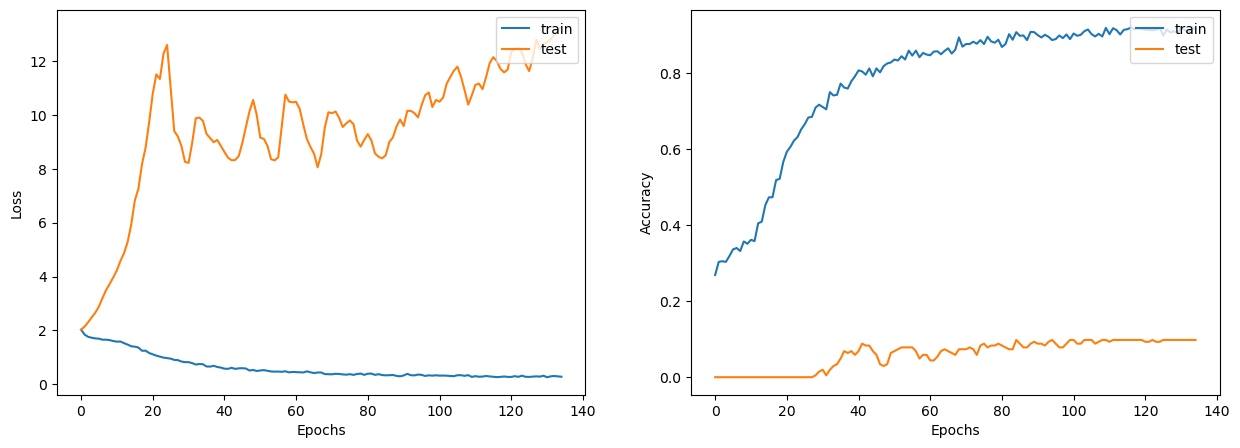

In [31]:
display_learning_curves(history)

In [32]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 74.0%


In [33]:
# First we add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
# Second we add the M edges (citations) from each new node to a set
# of existing nodes in a particular subject
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [34]:
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (2708, 1433)
Original edges shape: (2, 5429)
New node_features shape: (2715, 1433)
New edges shape: (2, 5478)
1/1 [==============================] - 2s 2s/step
Instance 1:
- Case_Based: 4.58%
- Genetic_Algorithms: 39.04%
- Neural_Networks: 7.39%
- Probabilistic_Methods: 20.13%
- Reinforcement_Learning: 8.2%
- Rule_Learning: 20.58%
- Theory: 0.08%
Instance 2:
- Case_Based: 0.21%
- Genetic_Algorithms: 74.8%
- Neural_Networks: 20.84%
- Probabilistic_Methods: 0.83%
- Reinforcement_Learning: 3.08%
- Rule_Learning: 0.24%
- Theory: 0.0%
Instance 3:
- Case_Based: 0.08%
- Genetic_Algorithms: 0.08%
- Neural_Networks: 10.37%
- Probabilistic_Methods: 89.15%
- Reinforcement_Learning: 0.18%
- Rule_Learning: 0.14%
- Theory: 0.0%
Instance 4:
- Case_Based: 0.73%
- Genetic_Algorithms: 0.17%
- Neural_Networks: 5.27%
- Probabilistic_Methods: 92.96%
- Reinforcement_Learning: 0.4%
- Rule_Learning: 0.47%
- Theory: 0.0%
Instance 5:
- Case_Based: 3.19%
- Genetic_Algorithms: 17.55%